## El filtro prototipo

### Diseño
El diseño del filtro prototipo se hace a partir de las especificaciones:

- frecuencia de pasa banda-> pb_freq

- frecuencia de stopband -> sb_freq

- magnitud del ripple máximo permitido en la passband -> pb_mag

- magnitud requerida de atenuación en la banda stpoband -> sb_mag

Todas estas especificaciones + el número de canales para el cual se diseña el filtro nos dan la longitud requerida del filtro -> filt_len

Esa longitud del filtro se puede estimar con la función firpmord() de matlab o 

(n,fo,ao,w) = remezord([0.05625,0.0625], [1,0], [11.447e-3,3.16e-5]) 

en el caso de python

Ej: [n,fo,mo,w] = firpmord([0.05625 0.0625], [1 0], [11.447e-3 3.16e-5]) de donde [0.05625 0.0625] esto sale de pb_freq = (1/K)*0.9 y sb_freq = (1/K)

- [1 0] sale de la forma que quiero del filtro, en este caso pasa-bajo
- [11.447e-3 3.16e-5] esto sale de pb_mag = 0.1 dB y sb_mag = 90 dB a su vez esos ultimos parámetros están relacionados con \delta y \delta_s (ver libro de Cristi)

- 0.1 = 20*log10(1+\delta_p)) => \delta_p = 11.447e-3
- -90 = 20*log10(\delta_s) => \delta_s = 3.16e-5

En MATLAB:

- [n,fo,mo,w] = firpmord([0.05625 0.0625], [1 0], [11.447e-3 3.16e-5])

- b=firpm(n,fo,mo,w);

- fvtool(b)

otra forma de llamar a firpmord usando la frecuencia de sampleo es la siguiente, con 383.97e-6 que sale de hacer \delta_p1 = \delta_p/3 (ver mis cálculos de filtro multi-etapas en la hoja 110 de mi cuaderno).

- [n,fo,mo,w] = firpmord([3.515625e6 3.90625e6], [1 0], [383.97e-6 1e-4],125e6)

Esto me da una primera aproximación a la cantidad de tap que debe tener el filtro a diseñar, que en este caso es de 1086 taps (longitud del filtro). Luego ese número lo debo adaptar a lo que voy a querer en mi core. Por ejemplo
si voy a tener 16 canales entonces debo buscar un número que divida por 16. En este ejemplo 1168/16 = 73-taps cada uno de mis filtros polifásicos (16).

En este caso hago el diseño de la primer etapa del filtro siguiendo mis cálculos en el cuaderno.

- [n,fo,mo,w] = firpmord([109.86e3 3.7842e6], [1 0], [383.97e-6 1e-4],125e6)

con eso compruebo el orden que había calculado en mi cuaderno para esta etapa

Python
Para el diseño en python lo que hay que recordar es que remez toma Fs=1Hz y Matlab toma Fs=2Hz.
Entonces

- (n,fo,ao,w) = remezord([0.05625,0.0625], [1,0], [11.447e-3,3.16e-5])

En este caso se usan los mismos valores que los usados en Matlab para hacer los cálculos porque la función remezord así lo requiere. Sin embargo, para usar la funcion signal.remez de python es necesario dividir los valores de frecuencia por 2, ya que Fs=1Hz acá. Prácticamente hablando, remezord es una función que me permite estimar el orden que va a tener mi filtro calculado con el algoritmo de Remez (minmax) y nada más que para eso. Básicamente obtengo el valor de n que me ayudará a ver la respuesta en frecuencia de mi filtro.

- b=remez(n,[0, 0.05625/2, 0.0625/2, 0.5],[1,0],w);

Importo los modulos necesarios

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.signal as sg 
from dsp_funcs import upsample, remezord, lporder, h_freqz, mfreqz, impz, zplane, coe_wr

Configuración.

In [2]:
fs        = 125e6    # sampling frequency
M         = 16       # downsampling ratio
I         = 1        # oversampling factor
K         = M*I      # number of channels
pb_mag    = 0.1;
sb_mag    = 66;
pb_freq   = (1/K)*0.80;
fc_freq   = (1/K)
sb_freq   = (1/M)
print(f'Frec. de corte: {fc_freq}, Frec. de PB: {pb_freq}, Frec. de SB: {sb_freq}')
print(f'Frec. de corte: {fc_freq*(fs/2)}, Frec. de PB: {pb_freq*(fs/2)}, Frec. de SB: {sb_freq*(fs/2)}')

Frec. de corte: 0.0625, Frec. de PB: 0.05, Frec. de SB: 0.0625
Frec. de corte: 3906250.0, Frec. de PB: 3125000.0, Frec. de SB: 3906250.0


In [3]:
# 0.1 = 20*log10((1+\delta_p)) => \delta_p = 11.447e-3
# -90 = 20 log10(\delta_s) => \delta_s = 3.16e-5
#delta_p = np.power(10,pb_mag/20)-1
#delta_s = np.power(10,-(sb_mag/20))
#Al estilo Proakis
delta_p = ((10**(pb_mag/20))-1)/((10**(pb_mag/20))+1)
delta_s = (1+delta_p)*10**(-sb_mag/20)
delta_ss = 10**(-sb_mag/20)
print('delta_p= {:.3e}'.format(delta_p))
print('delta_s= {:.3e}'.format(delta_s))
print('delta_s= {:.3e}'.format(delta_ss))

(n,fo,ao,w) = remezord([pb_freq,sb_freq], [1,0], [delta_p,delta_s])
Lf=n+1
print(f'Orden estimado= {n}')
print(f'Longitud estimada= {Lf}')

delta_p= 5.756e-03
delta_s= 5.041e-04
delta_s= 5.012e-04
Orden estimado= 464
Longitud estimada= 465


Ahora lo que tengo que encontrar es el número mayor o igual a n que sea divisible por K. Este numero es el que voy a pasarle a remez después. Lo busco en el rango n a n+100

In [5]:
for i in range(Lf, Lf+100):
    if i % K == 0:
        if (i/K)%2==0: #condición para asegurar que el numero de taps sea par (FIR Compiler) (orden impar)  
            print(f"El número elegido es (Lf): {i}.")
            filt_len = i
            break     
        else:
            continue       
    #print(f"No se encontró un numero divisible por {K} dentro de los primeros 100 valores después de {n}.")

print(f'Orden elegido del filtro  : {filt_len-1}')
print(f'Taps por filtro (Lfp)     : {(filt_len/K)}')
print(f'Taps por filtro (Lfp)     : {int(np.ceil(filt_len/K))}')
print(f'Taps por filtro 2p+1 (Lfp): {int(np.ceil(filt_len/K))+1}')

#b=remez(filt_len,[0, pb_freq/2, sb_freq/2, 0.5],[1,0],w);
proto=sg.remez(filt_len,np.array(fo)/2,ao[0::2],w);
pp=np.pad(proto,(10,10),'constant')
proto.tofile('coeff/prototipo.csv',sep=',',format='%.20f')

El número elegido es (Lf): 480.
Orden elegido del filtro  : 479
Taps por filtro (Lfp)     : 30.0
Taps por filtro (Lfp)     : 30
Taps por filtro 2p+1 (Lfp): 31


Hago una estimación del ancho que deben tener los coeficientes en el FIR.

Esta estimación es en base al máximo que tengo en mis coeficientes y en una precisión requerida de 18 bits (fraccionales).

In [6]:
print(max(abs(proto)))
print(min(abs(proto)))
#En base al máximo
pm_req=18+np.log2(max(proto))
print(f"Bits requeridos para los coeficientes: {pm_req}, redondeado: {np.ceil(pm_req)}")

#En base al minimo y 16 bits fijos de representación
pn_req=16/np.log2(min(abs(proto)))
print(f"Bits requeridos para los coeficientes: {pn_req}, redondeado: {np.floor(pn_req)}")

0.05532883254052972
2.413351977256415e-07
Bits requeridos para los coeficientes: 13.824175292911532, redondeado: 14.0
Bits requeridos para los coeficientes: -0.7278530801885612, redondeado: -1.0


Primera gráfica. Respuesta en frecuencia del filtro prototipo.

<IPython.core.display.Javascript object>


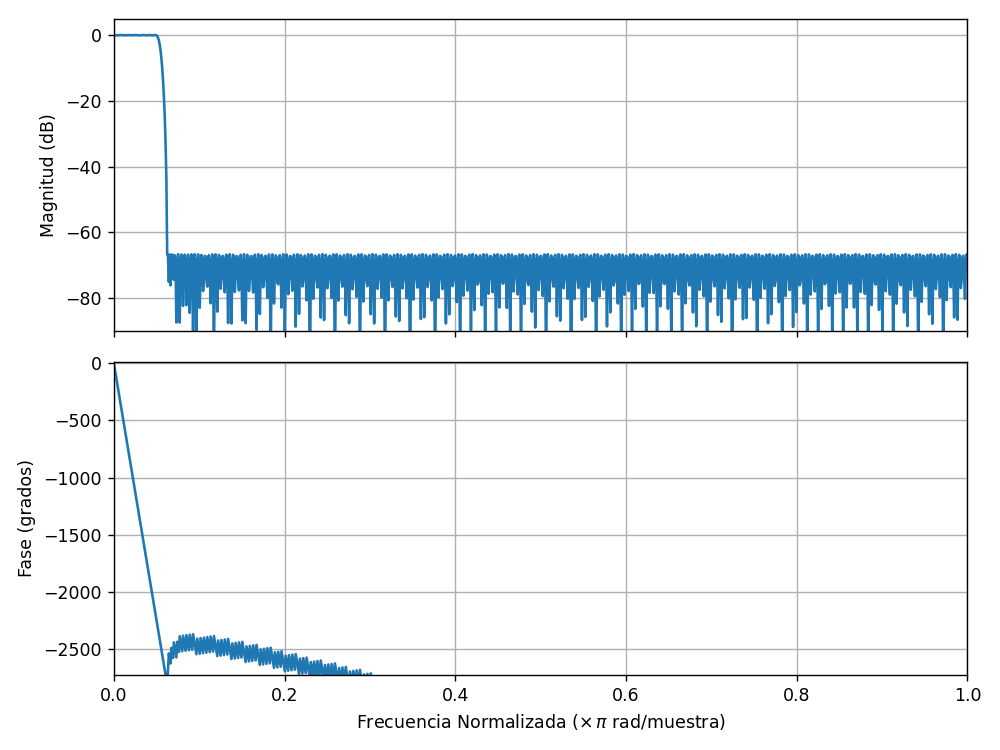

In [7]:
#plt.figure(figsize=(1,6))
#plt.figure()
#h_freqz(proto)
h_freqz(np.pad(proto,(10,10),'constant'))
plt.tight_layout()
plt.savefig('plots/prototipo.pdf')
#plt.show()

Respuesta al impulso del filtro prototipo

<IPython.core.display.Javascript object>


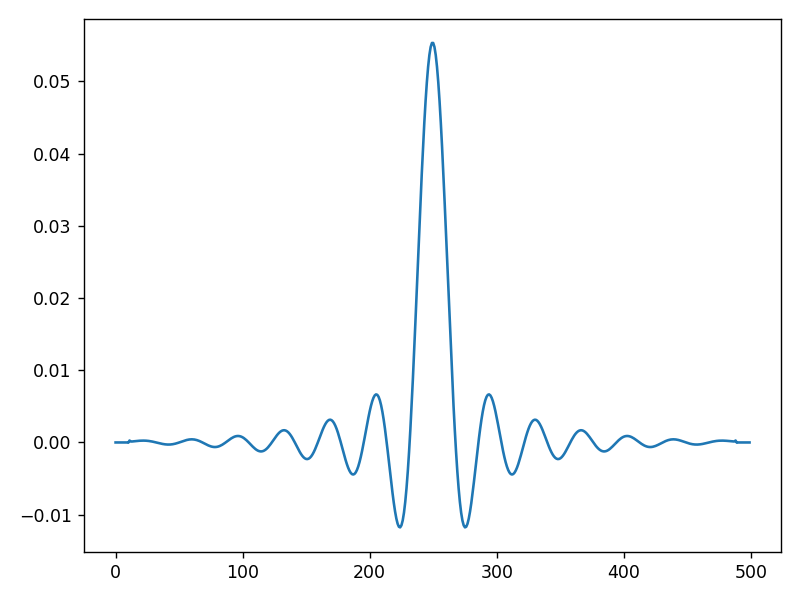

In [8]:
fig,ax = plt.subplots()
#ax.plot(proto)
ax.plot(np.pad(proto,(10,10),'constant'))
plt.tight_layout()
#plt.show()

<IPython.core.display.Javascript object>


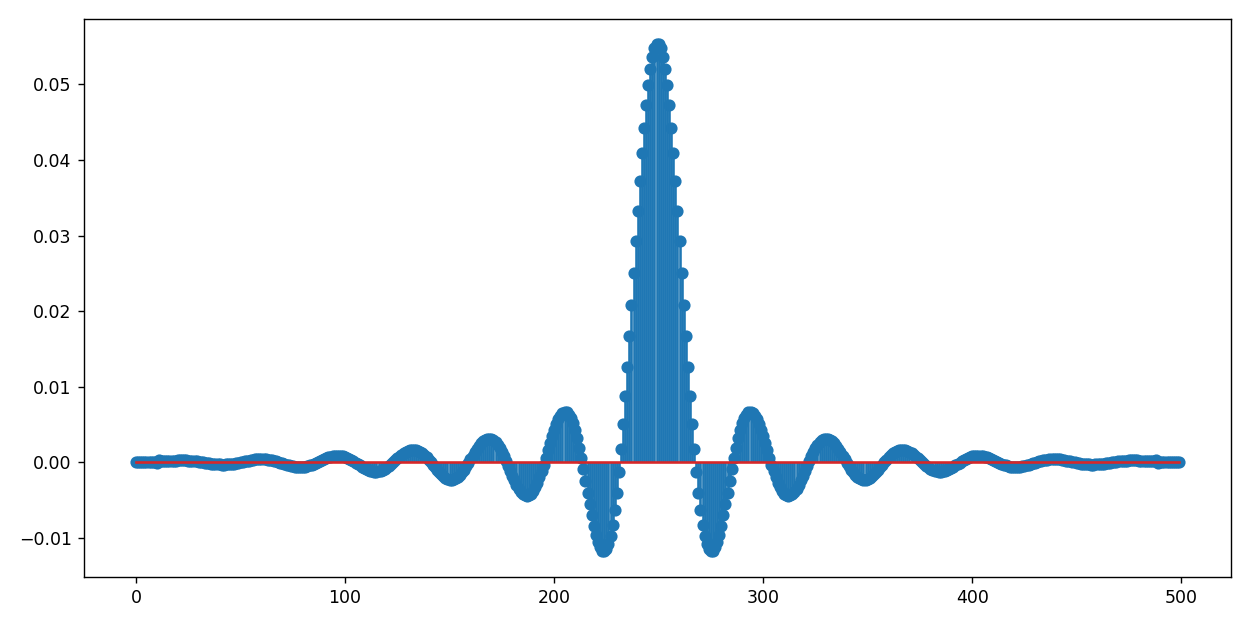

In [9]:
plt.figure(figsize=(10,5))
#plt.stem(proto,use_line_collection=1)
plt.stem(np.pad(proto,(10,10),'constant'),use_line_collection=1)
#plt.stem(proto[:int(len(proto)/2)],markerfmt='C1o',use_line_collection=1)
#plt.stem(proto[int(len(proto)/2):],markerfmt='C2o',use_line_collection=1)
#plt.stem(np.flipud(proto[int(len(proto)/2):]),markerfmt='C3o',use_line_collection=1)
#impz(proto)
plt.tight_layout()
#plt.show()

Ahora grafico en frecuencia solo la amplitud

<IPython.core.display.Javascript object>


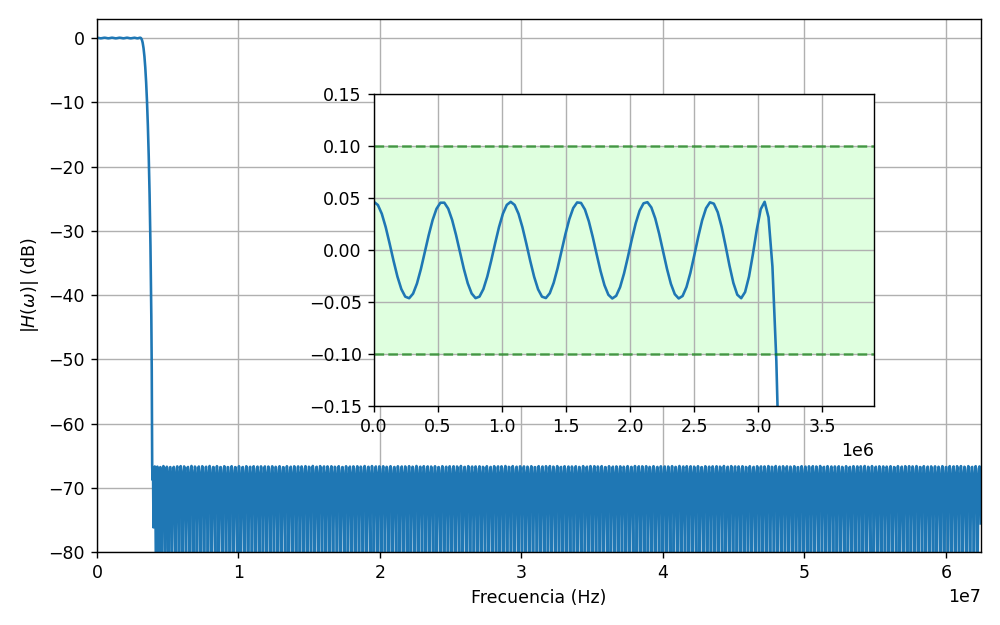

<ipython-input-10-d84704496a60>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [10]:
fig,ax = plt.subplots(figsize=(8,5))
w, h   = sg.freqz(proto, [1], worN=2048)
ax.plot(w*(0.5*fs)/np.pi, 20*np.log10(np.abs(h)))
ax.axis([0,fs/2,min(20*np.log10(np.abs(h))), max(20*np.log10(np.abs(h)))+5])
ax.set_xlabel('Frecuencia (Hz)')
#ax.set_ylabel('Amplitud (dB)')
ax.set_ylabel(r'$|H(\omega)|$ (dB)')
ax.set_ylim(-80,3)
ax.grid()
#ax.annotate('attenuated in\nstopband',fontsize=10,xy=(-40,3),
#        xytext=(50,3),textcoords='offset points',
#        arrowprops=dict(arrowstyle='->',lw=3),)
#ax[0].legend(loc='upper right',fontsize=5);
#ax[1].legend(loc='upper right',fontsize=5);

# this is an inset axes over the main axes
a = plt.axes([.374, .35, .5, .5], alpha=0.2)

a.plot(w*(0.5*fs)/np.pi, 20*np.log10(np.abs(h)))
a.axhline(0.1,c='green',ls='dashed',alpha=0.6)
a.axhline(-0.1,c='green',ls='dashed',alpha=0.6)
a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#a.set_xlim(0,3.2e6)
a.set_xlim(0,(fs/2)/M)
a.set_ylim(-0.15,0.15)
#a.autoscale()
a.grid()
# First plot the desired ideal response as a green(ish) rectangle.
low  = 0
high = 1e6
rect = plt.Rectangle((0,-0.1), fs/(2*K), 0.2, facecolor="#60ff60", alpha=0.2)
a.add_patch(rect)
plt.tight_layout()

plt.savefig(f'plots/prototipo_inset_{K}.pdf')

Ahora grafico el espectro completo. 
<!-- De acuerdo a lo que dice la pag. 360 de Crochiere, ahora corresponde armar los filtros polifásicos como $\bar{p}_\rho=h(mM-\rho)$, $\rho = 0,1,\ldots,M-1$. -->

<IPython.core.display.Javascript object>


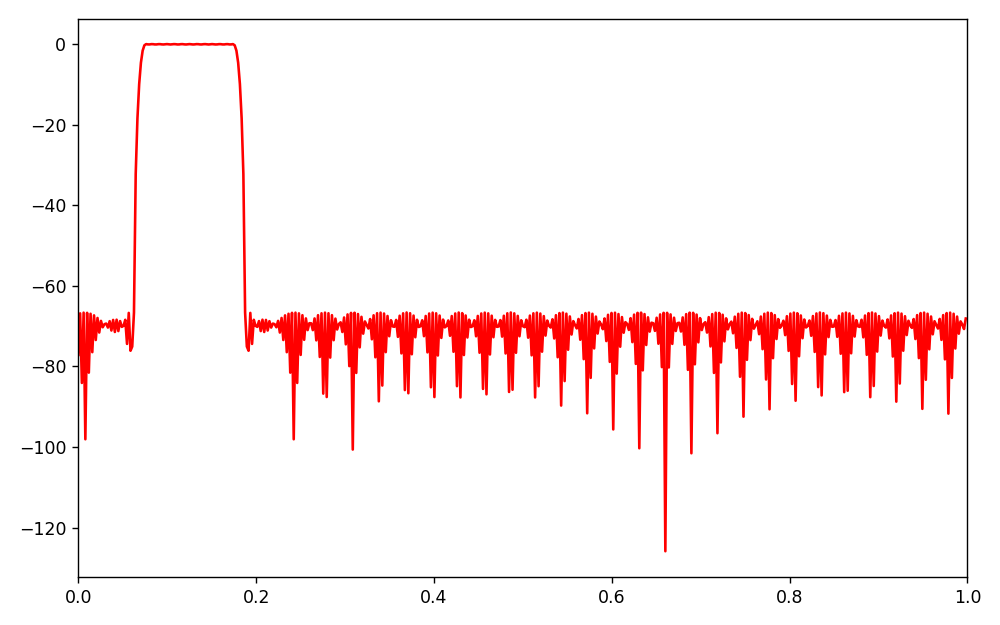

In [11]:
fig,ax=plt.subplots(figsize=(8,5))
bp_taps=np.zeros((K,proto.size),dtype=complex)
for k in range(K):
    bp_taps[k] = [lptap * np.exp(2j*np.pi*(k/(K))*n) for n, lptap in enumerate(proto)]
w, h = sg.freqz(bp_taps[1], [1], worN=512)
ax.plot(w/np.pi, 20*np.log10(np.abs(h)),'r')
ax.set_xlim(0,1)
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
bp_taps=np.zeros((K,proto.size),dtype=complex)
for k in range(K):
    if k<int(K/2):
        bp_taps[k] = [lptap * np.exp(2j*np.pi*(k/K)*n) for n, lptap in enumerate(proto)]
    else:
        bp_taps[k] = [lptap * np.exp(-2j*np.pi*(k/K)*n) for n, lptap in enumerate(proto)]

#to do it interactively
for r in range(K):
    w, h = sg.freqz(bp_taps[r], [1], worN=512)
    if r<int(K/2):        
        if r%2:
            ax.plot(w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'r')
        else:
            ax.plot(w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'b')
        #plt.pause(0.5)
    else:
        #w, h = freqz(bp_taps[r], [1], worN=512)
        if r%2:
            #need to flip the vector for circle rounding in the spectrum  
            ax.plot(-w*0.5*fs/np.pi, 20*np.log10(np.abs(np.flipud(h))),'r')
        else:
            ax.plot(-w*0.5*fs/np.pi, 20*np.log10(np.abs(np.flipud(h))),'b')
        #plt.pause(0.5)

w, h = sg.freqz(bp_taps[int(K/2)], [1], worN=512)
ax.plot(-w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'b')
ax.plot(w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'b')
ax.axis([-fs/2,fs/2,-90, 5])
#plt.title('Channelizer 16',fontsize=14)
ax.set_xlabel('Frecuencia (Hz)',fontsize=12)
ax.set_ylabel('Amplitud (dB)',fontsize=12)
ax.grid()
#plt.tight_layout()
plt.savefig('plots/n_filtros.pdf')
plt.show()

Para ver un solo canal y sus adyacentes. Primero grafico la respuesta ideal deseada en forma de un rectángulo verde.

<IPython.core.display.Javascript object>


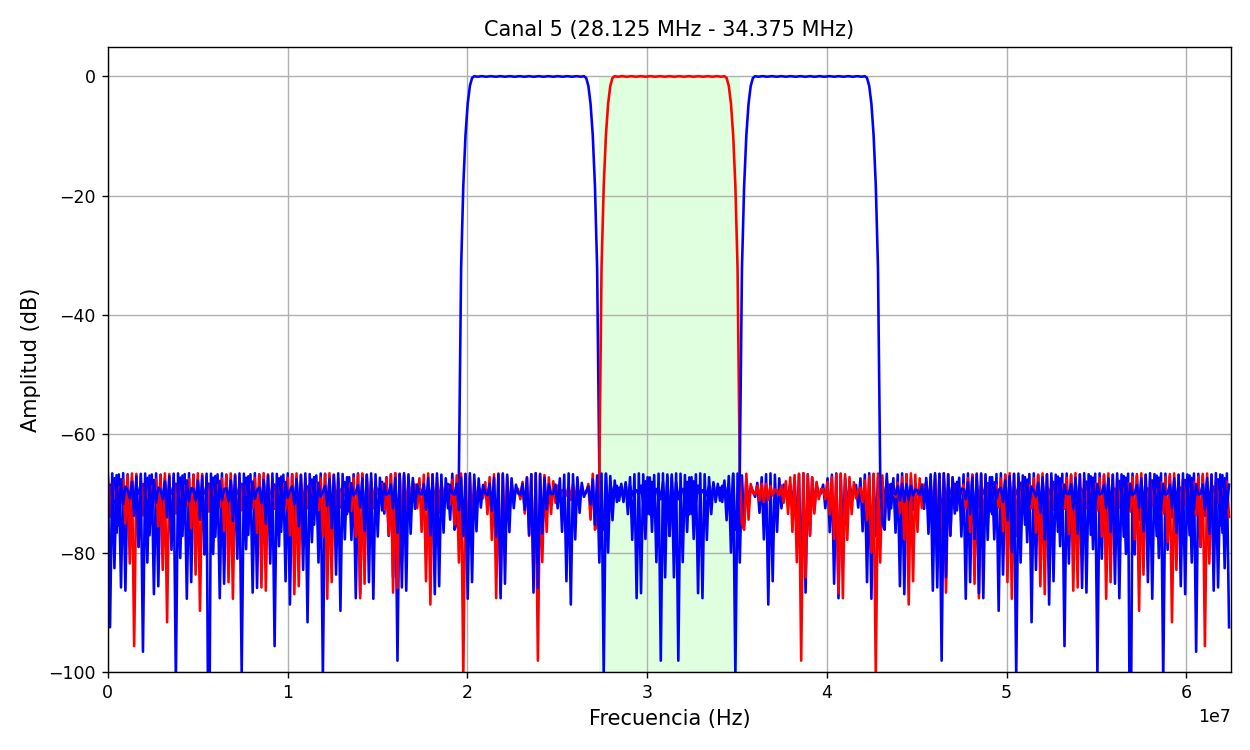

In [12]:
plt.figure(figsize=(10,6))
lowcut = 7*(fs/(2*K))
highcut = 9*(fs/(2*K))
rect = plt.Rectangle((lowcut, -150), highcut - lowcut, 150.0, facecolor="#60ff60", alpha=0.2)
plt.gca().add_patch(rect)
for r in range(3,6):
    w, h = sg.freqz(bp_taps[r], [1], worN=512)
    if r<int(K/2):        
        if r%2:
            plt.plot(w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'b')
        else:
            plt.plot(w*0.5*fs/np.pi, 20*np.log10(np.abs(h)),'r')
        #plt.pause(0.5)
    else:
        #w, h = freqz(bp_taps[r], [1], worN=512)
        if r%2:
            #need to flip the vector for circle rounding in the spectrum  
            plt.plot(-w*0.5*fs/np.pi, 20*np.log10(np.abs(np.flipud(h))),'r')
        else:
            plt.plot(-w*0.5*fs/np.pi, 20*np.log10(np.abs(np.flipud(h))),'b')
        #plt.pause(0.5)

plt.axis([0,fs/2,-100, 5])
#plt.title('Channelizer 16',fontsize=16)
#plt.title(f'Canal 5 ({7*((fs/(2*K))/1e6} MHz - {9*(fs/(2*K))/1e6} MHz)',fontsize=12)
plt.title(f'Canal 5 (28.125 MHz - 34.375 MHz)',fontsize=12)
plt.xlabel('Frecuencia (Hz)',fontsize=12)
plt.ylabel('Amplitud (dB)',fontsize=12)
plt.grid()
plt.tight_layout()
plt.savefig('plots/ch5_design.pdf')
plt.show()

## Filtros polifásicos de análisis ##

A partir de acá genero los filtros polifásicos del analizador, que van a ser los que cargue en los FIR Compilers después.

Reshape de los coeficientes del filtro en filtros polifásicos es decir, dividir en las K polifases. 

Acá es donde armo los filtros polifásicos: $\bar{p}_\rho(m) = h(mM-\rho),\quad\rho=0,1,...,M-1,\quad K=M$
    
Todo esto, según pag. 304 de Crochiere

In [13]:
#Primero hago la descomposición polifásica del prototipo en forma directa
ep1=np.zeros((K,int(proto.size/K)))
#ep1=np.zeros((K,int(np.pad(proto,(10,10),'constant').size/K)))
for ro in range(K): 
    ep1[ro]=proto[ro::K]
    #ep1[ro]=np.pad(proto,(10,10),'constant')[ro::K]
    
#agrego ceros en la columna final    
ep2=np.c_[ep1,np.zeros(K)]

#agrego ceros al inicio, desde la fila 1 en adelante. En el medio remuevo los ceros al final (d[:-1])
for i in range(1,K): 
    ep2[i]=np.pad(ep2[i][:-1],(1,0),'constant')

#Al final reordeno todo. Hago el flipud desde la fila 1 en adelante para dejar todo como tiene que estar.
ep3=np.vstack((ep2[0],np.flipud(ep2[1:,])))

#ep4=np.zeros((K,ep3.shape[1]*I))
#for ro in range(K): 
#    ep4[ro]=upsample(ep3[ro],I)
    
#Epp=ep4[:,:-1]
Epp=ep3

In [14]:
Ep=np.zeros((K,int(proto.size/K))) 
for ro in range(K):
    for m in range(int(proto.size/K)):
        Ep[ro][m] = proto[int(M*m-ro)] 

Agrego ceros al inicio de cada polyfilter y remuevo el ultimo elemento de cada filtro.

!!Este paso parece ser innecesario, lo comento por ahora.

In [15]:
#for ro in range(1,K):
#    Ep[ro] = np.roll(Ep[ro],-1) 
for ro in range(1,K):
    Ep[ro][0] = 0

Para graficar las respuestas de cada uno de los filtros prototipos

<IPython.core.display.Javascript object>


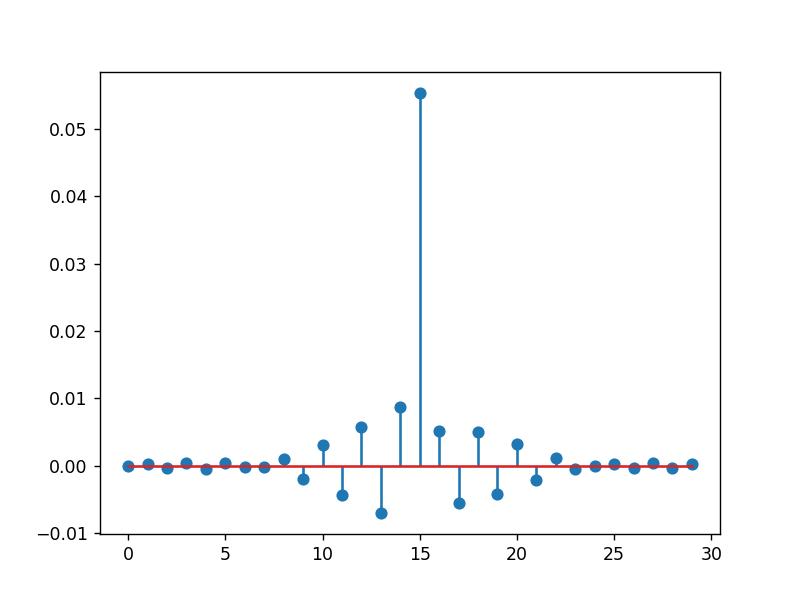

<IPython.core.display.Javascript object>


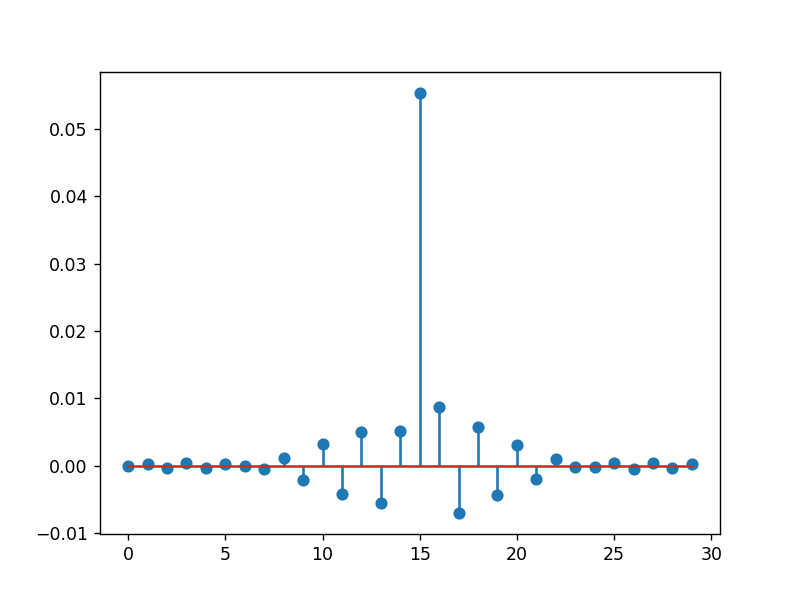

<IPython.core.display.Javascript object>


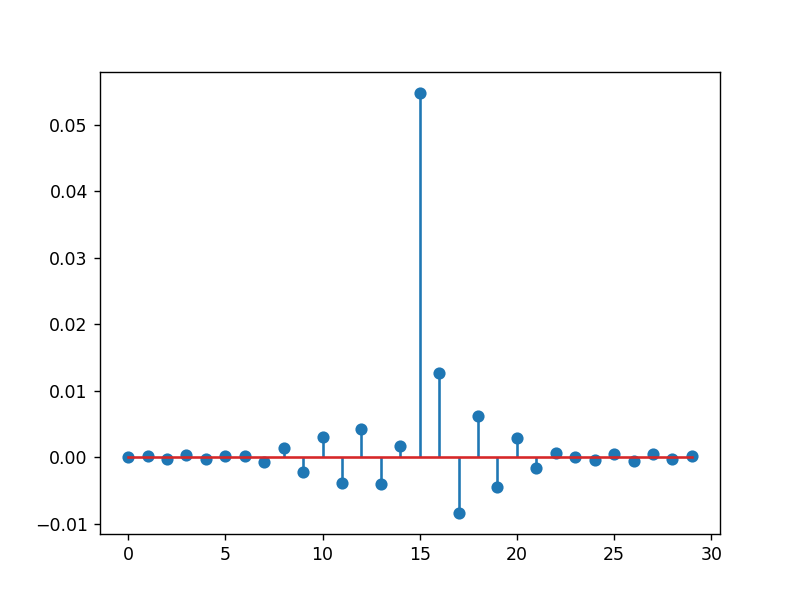

<IPython.core.display.Javascript object>


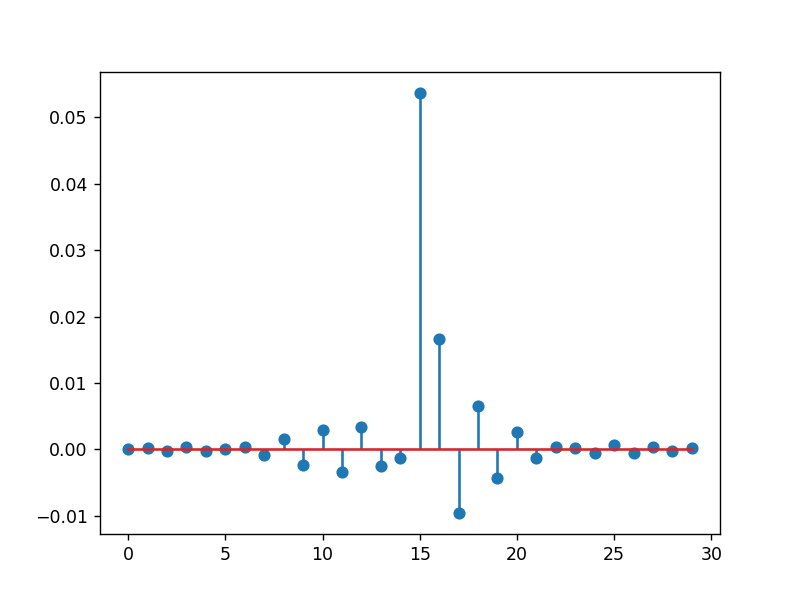

<IPython.core.display.Javascript object>


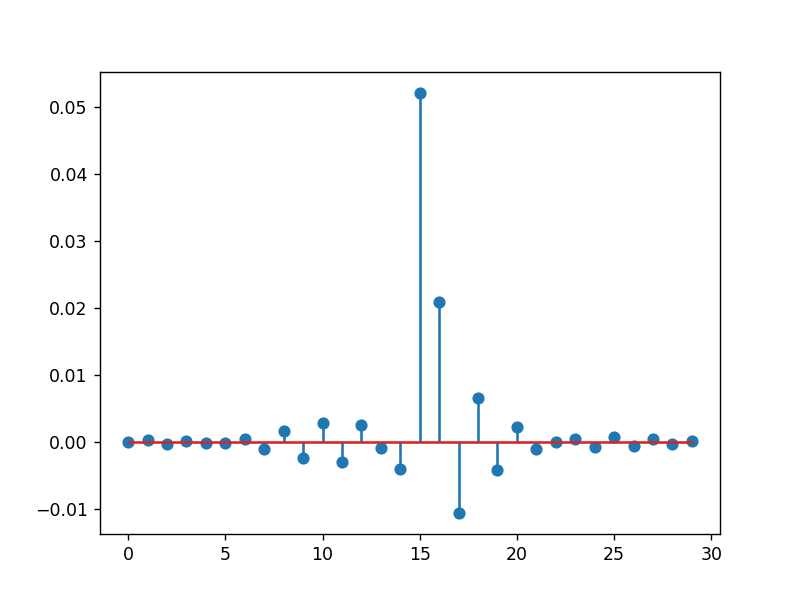

<IPython.core.display.Javascript object>


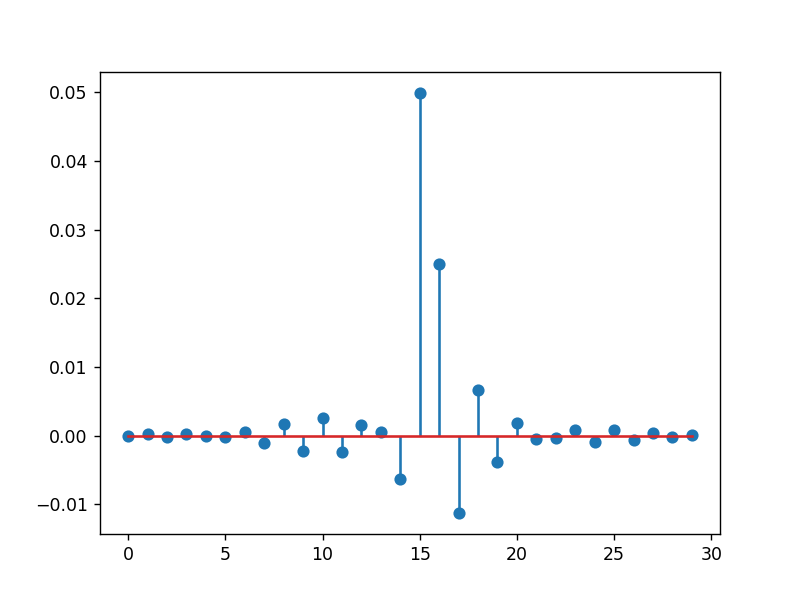

<IPython.core.display.Javascript object>


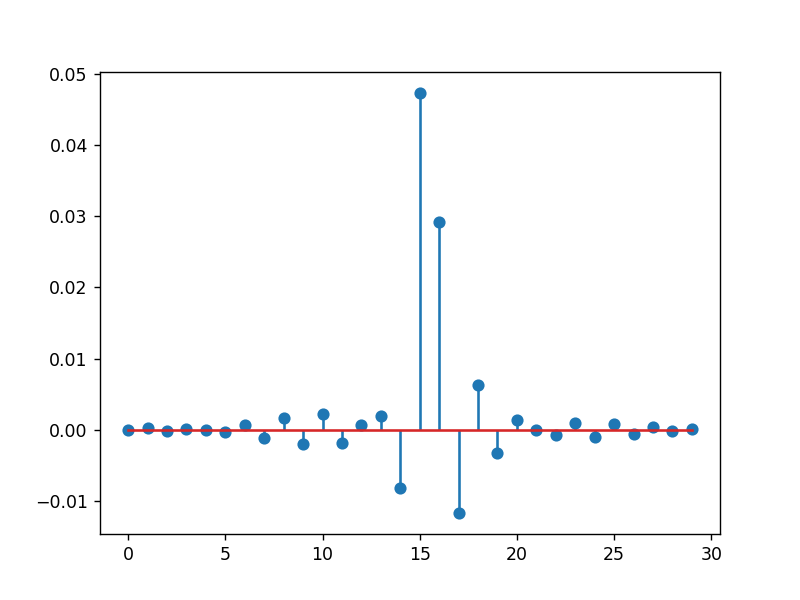

<IPython.core.display.Javascript object>


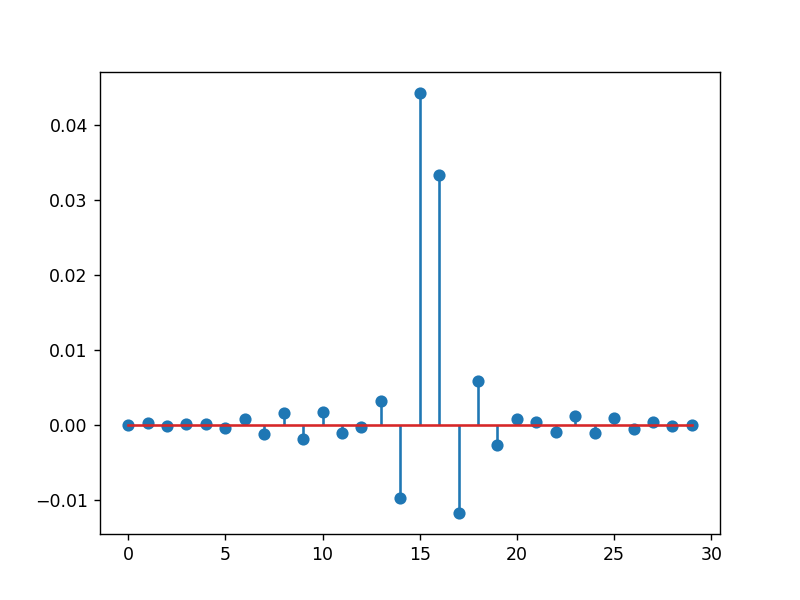

<IPython.core.display.Javascript object>


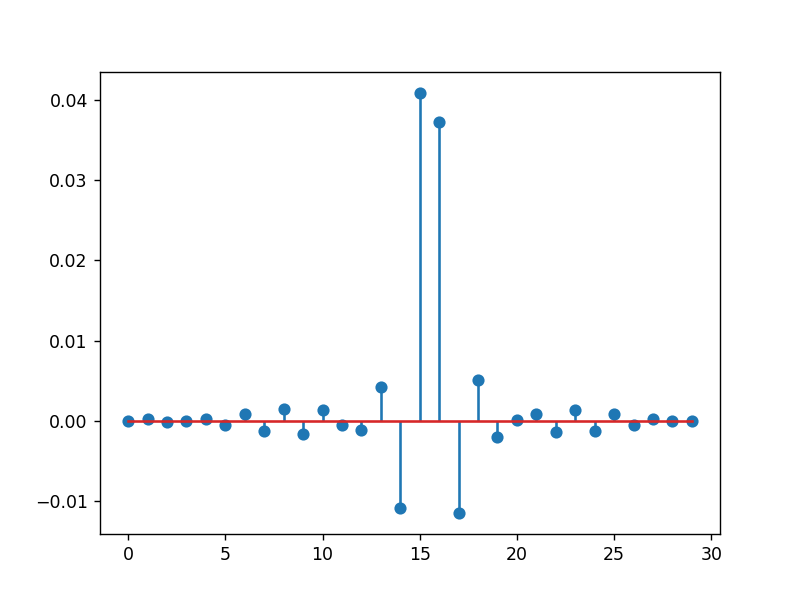

<IPython.core.display.Javascript object>


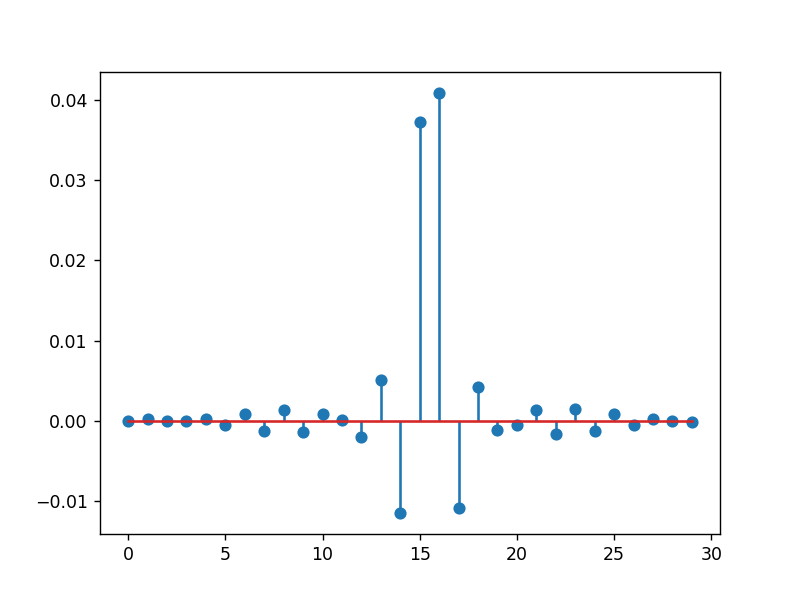

<IPython.core.display.Javascript object>


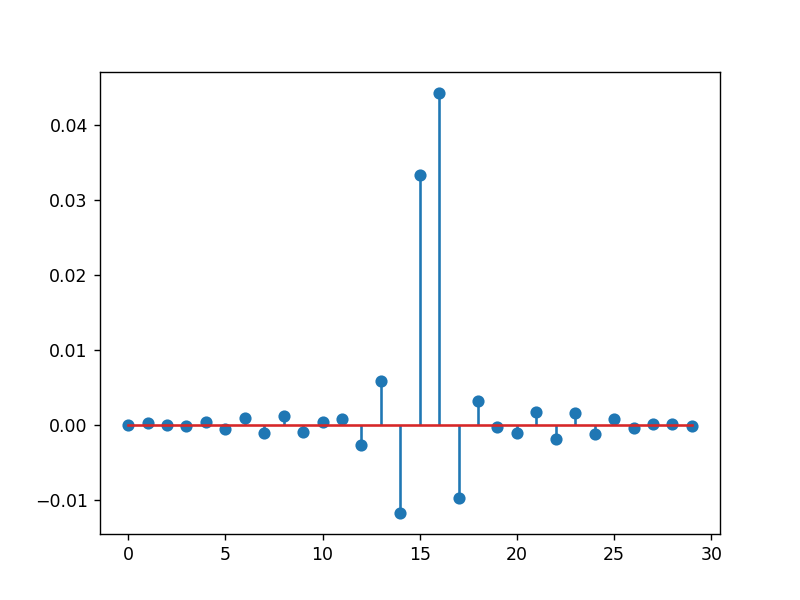

<IPython.core.display.Javascript object>


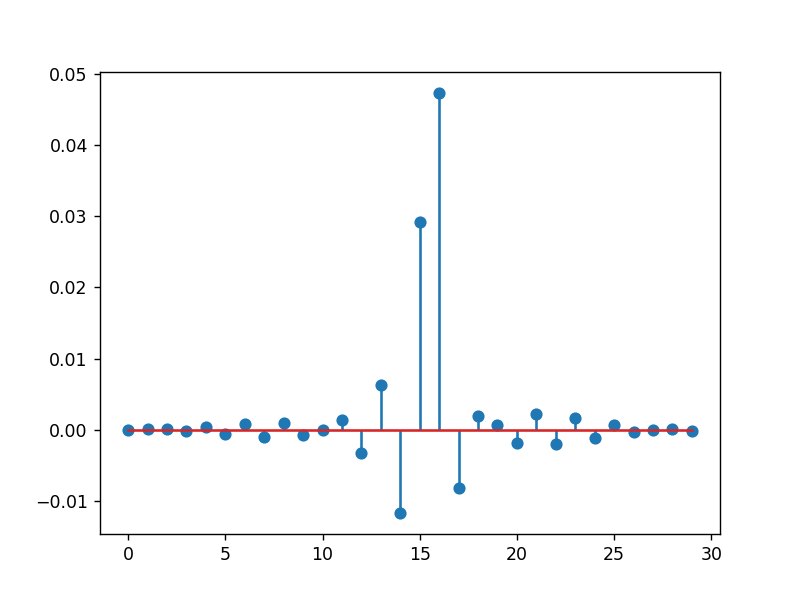

<IPython.core.display.Javascript object>


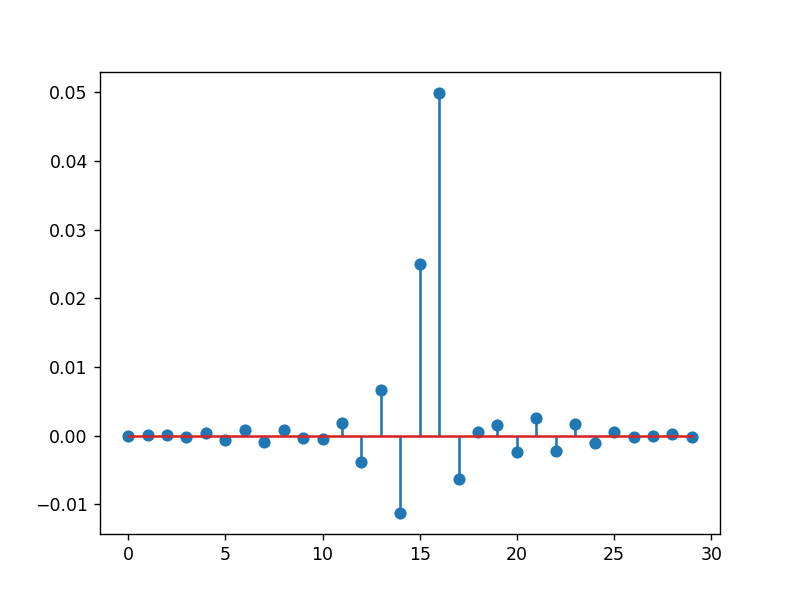

<IPython.core.display.Javascript object>


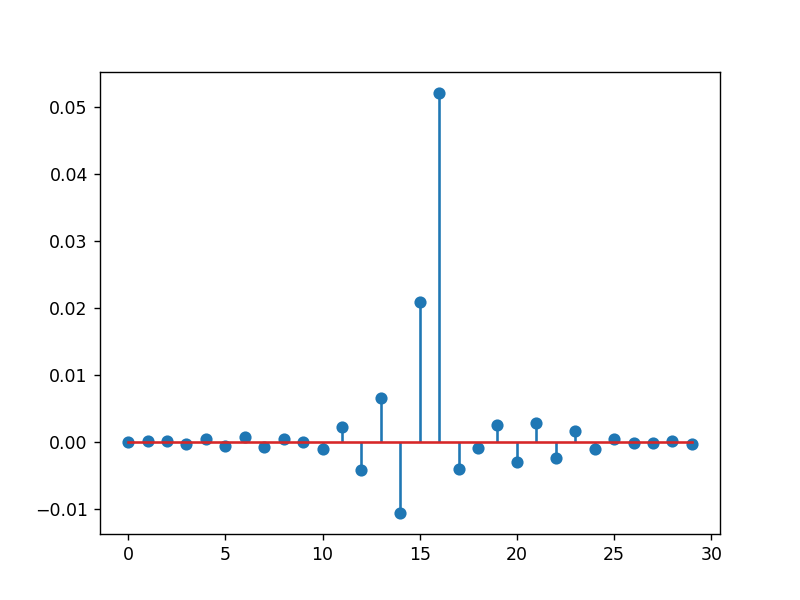

<ipython-input-16-583dd825e879>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots()


<IPython.core.display.Javascript object>


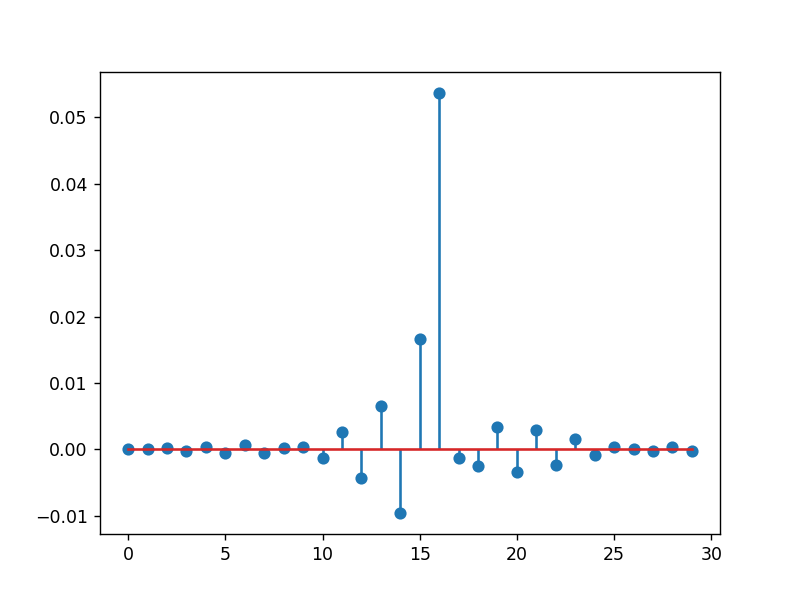

<ipython-input-16-583dd825e879>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots()


<IPython.core.display.Javascript object>


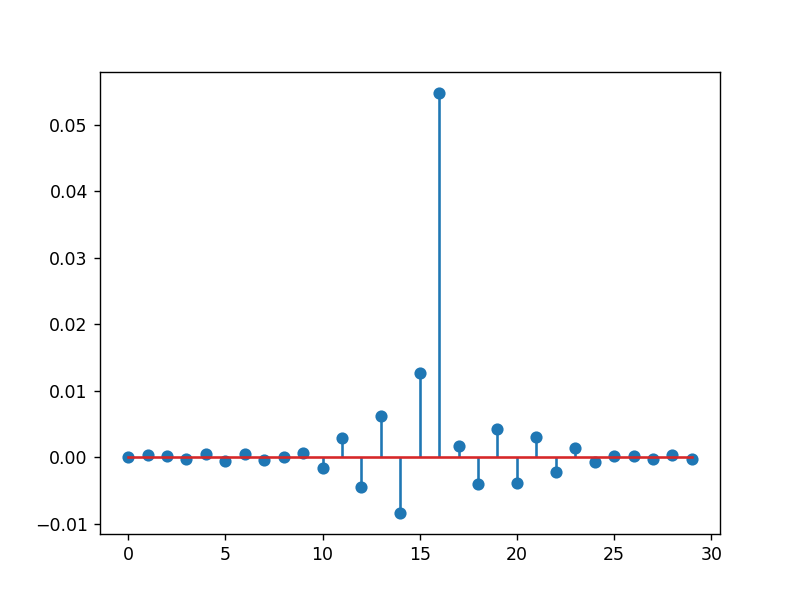

In [16]:
#plt.figure()
for i in range(K):
    plt.subplots()
    #plt.stem(filts[i], linefmt='C'+str(i))
    #plt.stem(fil[i], linefmt=''.format(plt.cm.cool(i)))
    plt.stem(Ep[i],use_line_collection=True)
    #plt.pause(1)
plt.show()

In [ ]:
#plt.figure()
for i in range(K):
    plt.subplots()
    #plt.stem(fil[i],'r')
    plt.stem(Ep[i],use_line_collection=True)
    #plt.stem(ep1[i],linefmt=f'C{i}',use_line_collection=True)
    plt.tight_layout()
    #plt.pause(1)
    plt.savefig('plots/filter/f{}_impulse_resp.pdf'.format(i))
plt.show()

In [ ]:
plt.clf()
for i in range(K):
    #mfreqz(fil[i])
    #mfreqz(K*Ep[i])
    h_freqz(Ep[i])
    plt.tight_layout()
    plt.savefig('plots/filter/f{}.pdf'.format(i))
plt.show()

<ipython-input-17-5dafcc67e7c9>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 6))


<IPython.core.display.Javascript object>


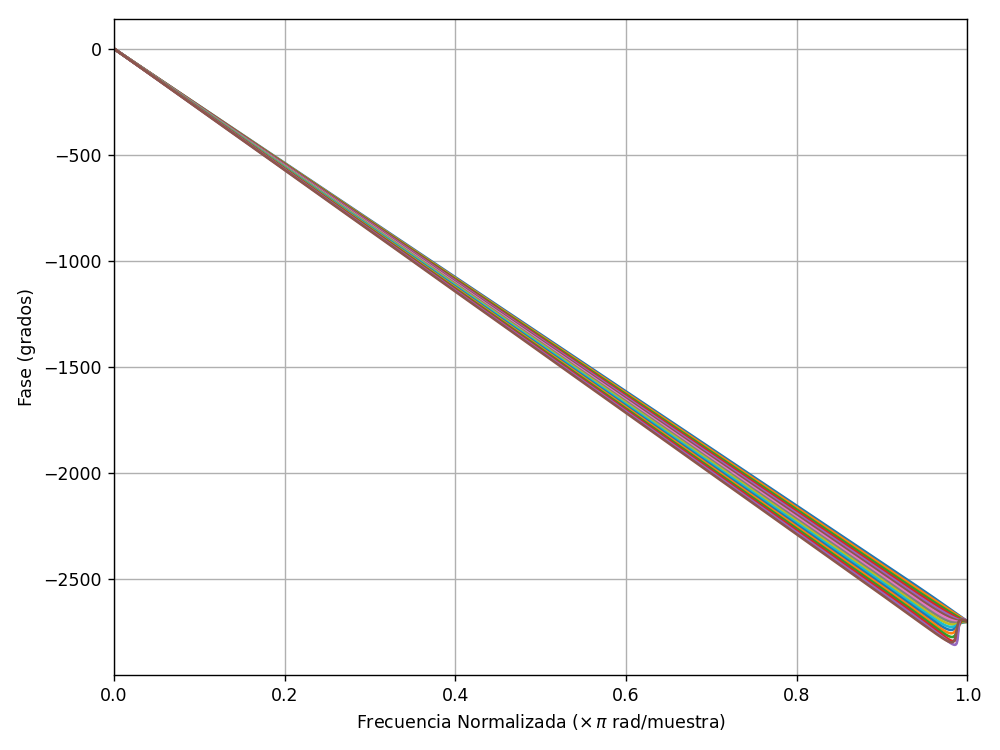

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 6))
for i in range(K):
    w,h = sg.freqz(Ep[i],1,worN=1024)
    #w,h = sg.freqz(b,a)
    #h_dB = 20 * np.log10(np.abs(h))
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)))
    #fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 6))
    #ax[0].plot(w/np.max(w),h_dB)
    #ax[0].grid()
    #ax[0].set_ylim(-90, 5)
    #ax[0].set_xlim(0, 1)
    #ax[0].set_ylabel('Magnitude (dB)')
    #ax[0].set_ylabel('Magnitud (dB)')
    #ax[0].set_xlabel(r'Normalized Frequency (x $\pi$ rad/sample)')
    #ax[0].set_title(r'Frequency response')
    #ax[0].set_title(r'Respuesta en frecuencia')
    #ax[0].autoscale(tight=1)
    #ax[0].autoscale()
    #plt.subplot(212)
    ax.plot(w/np.max(w),(180/np.pi)*h_Phase)
    #ax.plot(w/np.max(w),h_Phase)
    ax.grid()
    ax.set_xlim(0, 1)
    #ax[1].ylabel('Phase (radians)')
    #ax[1].set_ylabel('Phase (degrees)')
    ax.set_ylabel('Fase (grados)')
    #ax[1].set_xlabel(r'Normalized Frequency (x $\pi$ rad/sample)')
    ax.set_xlabel(r'Frecuencia Normalizada ($\times\,\pi$ rad/muestra)')
    #ax.set_ylim(-2720, 5)

    #mfreqz(fil[i])
    #mfreqz(K*Ep[i])
    #h_freqz(K*Ep[i])
ax.grid()
plt.tight_layout()
plt.savefig('plots/filter/phase_of_all.pdf')
plt.show()

Ahora guardo los coeficientes de los filtros en archivos separados

In [19]:
for i in range(K):
    coe_wr(Ep[i],'coeff/filter/coeff_{}.coe'.format(i))
#for i in range(K):
#    f=open('coeff/filter/coeff_{}.coe'.format(i),'w')
#    f.write('radix=10;\n')
#    f.write('coefdata=')
#    for j in range(Ep[i].size):
#        f.write('{:.20f}'.format(K*Ep[i][j]))
#        if j == Ep[i].size-1:
#            f.write(';')
#        else:
#            f.write(',')
#    f.close()

Generamos el archivo channelizer_{K}_{pb_mag}_{sb_mag}_{pb_freq}_{sb_freq}.coe directamente

In [20]:
m=np.array([])
for i in range(K):
    m=np.append(m,Ep[i])
    #m=np.append(m,b[i::K])
    #m=np.append(m,d[i::K])
coe_wr(m,f'coeff/channelizer_{K}_{pb_mag}_{sb_mag}_{pb_freq}_{sb_freq}.coe')

#f=open(f'coeff/channelizer_{K}_{pb_mag}_{sb_mag}_{pb_freq}_{sb_freq}.coe','w')
#f.write('radix=10;\n')
#f.write('coefdata=')
#for i in range(m.size):
#    f.write('{:.20f}'.format(m[i]))
#    if i == m.size-1:
#        f.write(';')
#    else:
#        f.write(',')
#f.close()